# Stimuli Generator

In [3]:
%matplotlib inline

import os
from pathlib import Path

import numpy as np
import scipy

# import sklearn

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.pyplot import *

import pygestalt as gs
from pygestalt import sampler

In [2]:
outdir = Path(os.getcwd()) / 'outputs'
os.makedirs(outdir, exist_ok=True)

## Comparison of sampling methods

### Method 1: iid uniform sampling

Drawback: formation of clusters

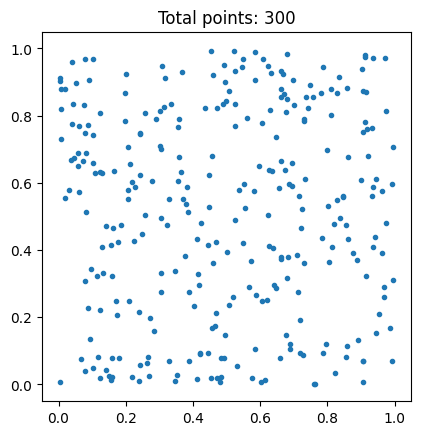

In [3]:
D = np.random.rand(300,2)
fig, ax = gs.utils.ball_plot(D)

### Method 2: random perturbation of hexagonal grid

Depending on the amount of perturbation:
- Insuffificent: still look like a hex grid
- Too much: formation of clusters

In [4]:
ρ = 0.03
# print(f'Radius={ρ}, Maximum number of balls={int(1/(np.pi*ρ**2))}')

N = int(1/ρ)
X, Y = np.meshgrid(np.arange(0,2*N), np.arange(-2*N,2*N))

# Hexagonal coordinates
B = np.asarray([[1,0], [0.5, np.sqrt(3)/2]]).T

H0 = np.asarray((X,Y)).reshape((2,-1)).T @ B * (2*ρ)
Hg = np.asarray([d for d in H0 if 0<=d[0]<=1 and 0<=d[1]<=1])

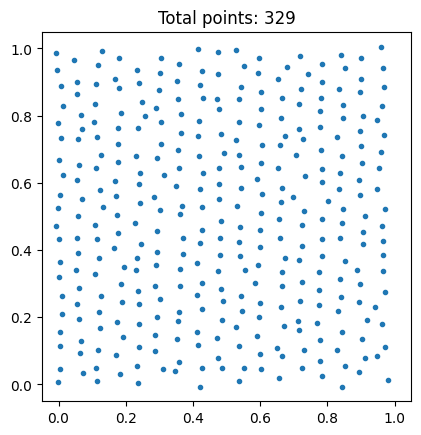

In [5]:
D = Hg + np.random.randn(len(Hg),2)*ρ*0.25

_ = gs.utils.ball_plot(D)

### Method 3: incremental sampling

Try to pack randomly as many balls as possible inside a restricted area. 

In [6]:
sfunc = gs.sampler.box()
radius = 0.025
thresh = 1e-1

%time D = gs.sampler.draw_positions(radius, sfunc, thresh=thresh)

CPU times: user 104 ms, sys: 4.29 ms, total: 108 ms
Wall time: 108 ms


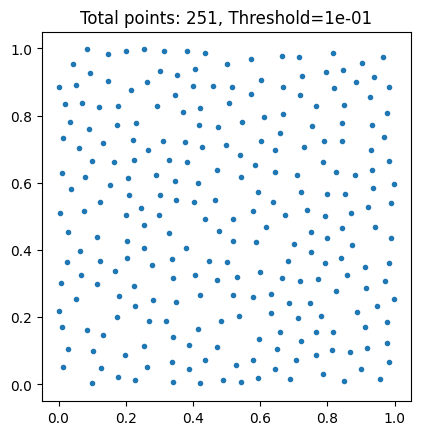

In [7]:
_ = gs.utils.ball_plot(D, thresh=thresh)

## Incremental sampling

### Effect of the threshold

Sampling becomes harder with a small threshold.

In [8]:
sfunc = gs.sampler.box()
radius = 0.1
thresh = 1e-3

%time D = gs.sampler.draw_positions(radius, sfunc, thresh=thresh)

len(D)

CPU times: user 770 ms, sys: 7.93 ms, total: 778 ms
Wall time: 784 ms


28

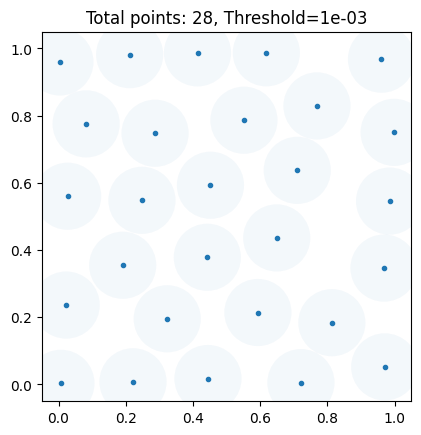

In [9]:
fig, ax = gs.utils.ball_plot(D, radius=radius, thresh=thresh)

# plt.savefig(outdir/f'thresh[{thresh:.0e}].png')

### Sampling from a contour

In [10]:
radius = 0.025
thresh = 1e-2

# %time C = sampling(radius, point_set(Xs), thresh=thresh)
%time C = sampler.draw_positions(radius, sampler.circle(inside=False), thresh=thresh)
%time D = sampler.draw_positions(radius, sampler.box(), exclusions=C, thresh=thresh)

CPU times: user 103 ms, sys: 6.07 ms, total: 109 ms
Wall time: 107 ms
CPU times: user 1.27 s, sys: 8.15 ms, total: 1.28 s
Wall time: 1.29 s


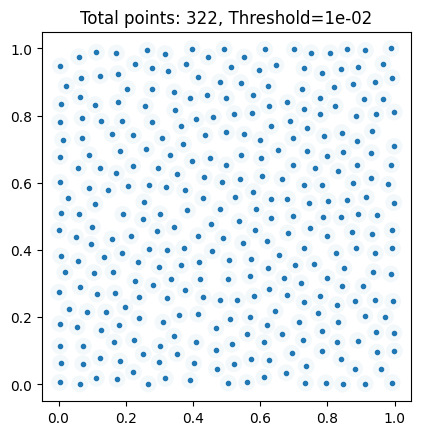

In [11]:
fig, ax = gs.utils.ball_plot(np.vstack([D, C]), radius=radius, thresh=thresh)

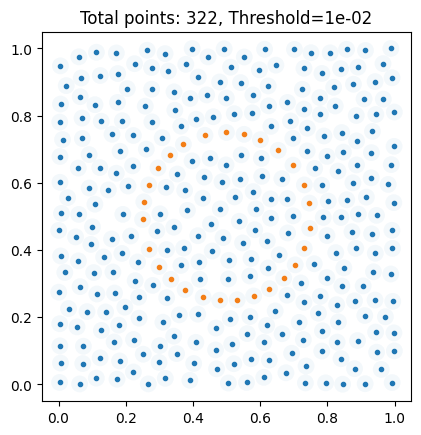

In [12]:
fig, ax = gs.utils.ball_plot(D, C, radius=radius, thresh=thresh)

In [13]:
P = np.asarray ([(0.25,0.25), (0.75,0.25), (0.5,0.683), (0.25,0.25)])

radius = 0.025
thresh = 1e-3

# %time C = sampling(radius, point_set(Xs), thresh=thresh)
%time C = sampler.draw_positions(radius, sampler.segments(P), thresh=thresh)
%time D = sampler.draw_positions(radius, sampler.box(), exclusions=C, thresh=thresh)

CPU times: user 801 ms, sys: 13.1 ms, total: 814 ms
Wall time: 819 ms
CPU times: user 13.9 s, sys: 96.4 ms, total: 14 s
Wall time: 14.1 s


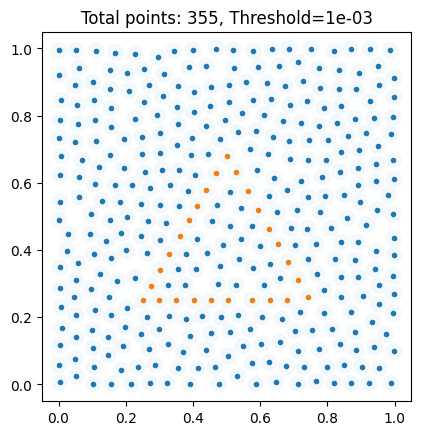

In [14]:
fig, ax = gs.utils.ball_plot(D, C, radius=radius, thresh=thresh)

### Sampling from a contour of image

In [15]:
fname = Path('/Users/han/Dropbox/Projects/DeepBrain/Datasets/hare_1024.png')
image = plt.imread(fname)

X0 = np.mean(image, axis=-1)
plt.imshow(X0, aspect='equal')

FileNotFoundError: [Errno 2] No such file or directory: '/Users/han/Dropbox/Projects/DeepBrain/Datasets/hare_1024.png'

In [25]:
X1, Xs, Gs = gs.utils.contour_from_cartoon(X0)

Xs = Xs/X1.shape  # convert to the coordinate in the box [0,1]x[0,1]

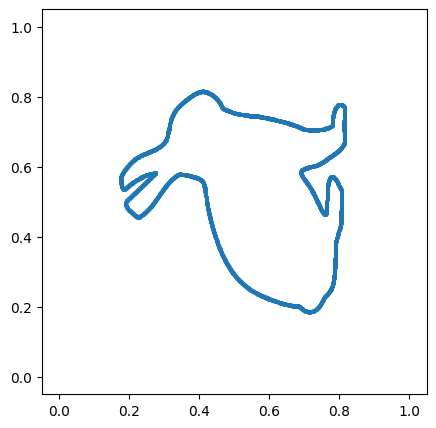

In [26]:
plt.scatter(Xs[:,0], Xs[:,1], marker='.', s=1)
ax = plt.gca()
ax.set_xlim((-0.05,1.05))
ax.set_ylim((-0.05,1.05))
ax.set_aspect('equal')

In [29]:
radius = 0.03
thresh = 1e-2

%time C = sampler.draw_positions(radius, sampler.point_set(Xs), thresh=thresh)
%time D = sampler.draw_positions(radius, sampler.box(), exclusions=C, thresh=thresh)

CPU times: user 89.6 ms, sys: 8.87 ms, total: 98.5 ms
Wall time: 91 ms
CPU times: user 903 ms, sys: 8.88 ms, total: 912 ms
Wall time: 917 ms


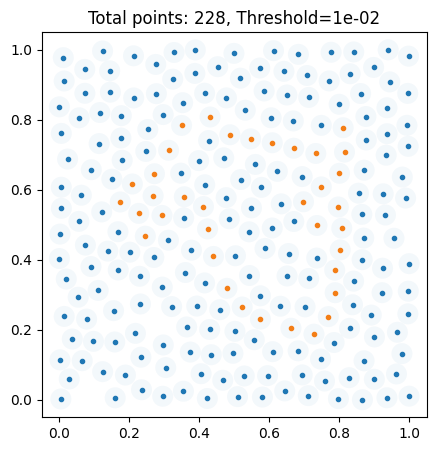

In [30]:
fig, ax = gs.utils.ball_plot(D, C, radius=radius, thresh=thresh)

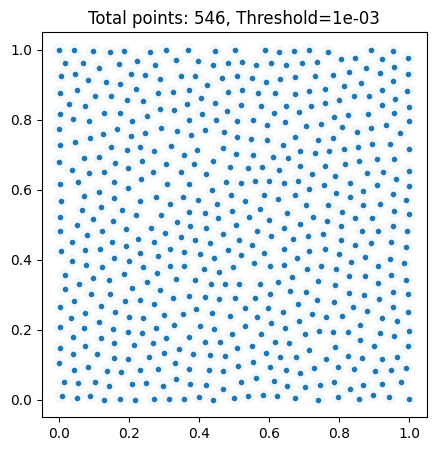

In [34]:
fig, ax = gs.utils.ball_plot(np.vstack([D,C]), radius=radius, thresh=thresh)

### Placement of patches

In [36]:
N = 512
xs, ys = np.meshgrid(range(N), range(N))
xys = np.stack([xs,ys]).reshape((2,-1)).T/N

In [37]:
xys.shape

(262144, 2)

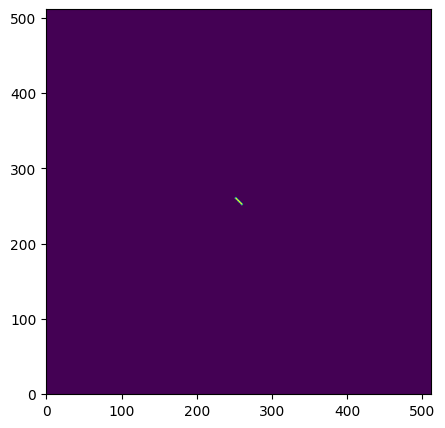

In [44]:
I = gs.patch.segment(xys-[0.5,0.5], g=[1,1], l=0.025, w=0.005, ).reshape(N,N)
# I = gs.patch.gabor(xys-[0.5,0.5], f=100, σ2=0.002, g=[1,1]).reshape(N,N)

plt.imshow(I, origin='lower')

In [126]:
f = 100
σ2 = 0.002

l=0.025
w=0.005

# pfunc = lambda z,g: gs.patch.gabor(z, g, f, σ2)
pfunc = lambda z,g: gs.patch.segment(z, g, l, w)

In [127]:
N = 512
If = gs.patch.generate_image(C, Xs, Gs, N=N, pfunc=pfunc)
Ig = gs.patch.generate_image(D, N=N, pfunc=pfunc)

I = If + Ig

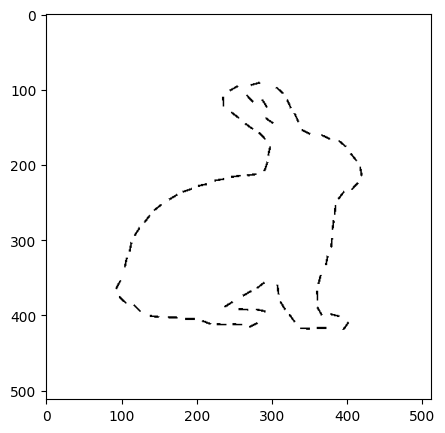

In [128]:
Im = If.copy()

Im = np.fliplr(np.rot90(Im,-1))

plt.imshow(Im, aspect='equal')
plt.set_cmap('binary')
plt.imsave(outdir/f'bunny{N}_fg.png', Im)

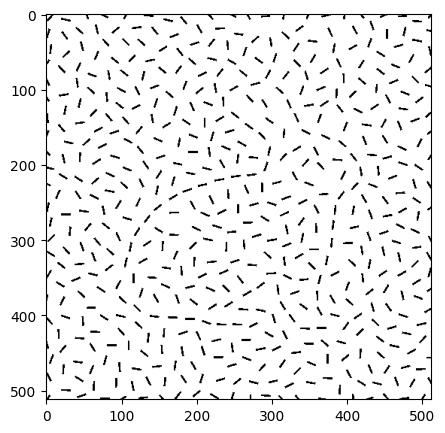

In [129]:
Im = I.copy()

Im = np.fliplr(np.rot90(Im,-1))

plt.imshow(Im, aspect='equal')
plt.set_cmap('binary')
plt.imsave(outdir/f'bunny{N}.png', Im)

# EOF